In [1]:
import requests as r 
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
#CLEANER LES 2 TABLES POUR GARDER COLONNES INTERESSANTES

## 1. Import datas & data cleaning

### Import data fertility from wikipedia

In [2]:
def scrape_and_merge():

    happy=pd.read_csv('data/2020.csv')
    happy.rename(columns={'Country name':'Country'},inplace=True)

#add the table about fertility rate
    url='https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependencies_by_total_fertility_rate'
    fertility=pd.read_html(url)
    fert_tab=fertility[4][['Country','Fertility rate 2020 estimate (births/woman)']]
   
 
#add the table about urbanisation rate
    url2='https://en.wikipedia.org/wiki/Urbanization_by_country'
    urban=pd.read_html(url2)
    urban_tab=urban[0][['Nation','Urban Population (%)']]
    urban_tab.rename(columns={'Nation':'Country'},inplace=True)


#add the table about sunshine duration
    url = 'https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration'
    html=r.get(url).content
    soup=BeautifulSoup(html)

    """
    1 table per continent, several rows per country(1row=1city), 
    so concatenation of all the tables, group by country, with mean of sunshine duration 
    """

    continent = ['africa', 'asia', 'europe','american','americas','oceania']
    col=['Country', 'City', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Year', 'Ref.']
    df_sunny=pd.DataFrame(columns=col)

    for i in range(len(continent)):
        table=soup.select('table.sortable')[i]
        rows = table.find_all('tr')
        table =[[cell.strip() for cell in i.text.strip().split('\n') if cell!=''] for i in rows]
        df_sunny = pd.concat([df_sunny, pd.DataFrame(table[1:], columns=col)], ignore_index=True)

    df_sunny['Year']=df_sunny['Year'].str.replace(',','').astype('float64')
    df_sunny = df_sunny.pivot_table(index=['Country'], values='Year', aggfunc='mean')
    
#merge all tables
    merge1=pd.merge(happy,fert_tab,on='Country', how='left')
    merge2=pd.merge(merge1,urban_tab,on='Country', how='left')
    df=pd.merge(merge2,df_sunny,on='Country', how='left')

    return df
    

### Merge the 2 tables (fertility and happiness_202) on country

In [3]:
scrape_and_merge()

C:\Users\DB\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Country,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,...,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Fertility rate 2020 estimate (births/woman),Urban Population (%),Year
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,...,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.74,85.5,1858.000000
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,...,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,1.78,88.1,1568.000000
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,...,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,1.57,73.9,1566.000000
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,...,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,1.97,93.9,1326.000000
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,...,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,1.84,83,1373.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,...,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,4.14,42.2,2546.500000
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,...,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,3.52,17.4,NaN
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,...,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,3.93,32.2,3065.400000
151,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,...,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,5.54,20.2,2841.300000


### Function to clean data

In [4]:
def cleaning(df):
    df=df.rename(columns = {'Year': 'Sunshine duration per Year','Fertility rate 2020 estimate (births/woman)':'Fertility rate'})
    df['Urban Population (%)']=df['Urban Population (%)'].str.replace("\[2\]", '')
    df = df.astype({'Fertility rate': np.float64, 'Urban Population (%)': np.float64})
    df=df[['Country','Regional indicator','Ladder score','Logged GDP per capita','Social support','Healthy life expectancy','Freedom to make life choices','Generosity','Perceptions of corruption','Fertility rate','Urban Population (%)','Sunshine duration per Year']]

#filling missing values
    df['Fertility rate']= df[['Regional indicator','Fertility rate']].groupby("Regional indicator").transform(lambda x: x.fillna(x.mean()))
    df['Urban Population (%)']= df[['Regional indicator','Urban Population (%)']].groupby("Regional indicator").transform(lambda x: x.fillna(x.mean()))
    df['Sunshine duration per Year']= df[['Regional indicator','Sunshine duration per Year']].groupby("Regional indicator").transform(lambda x: x.fillna(x.mean()))
    return df

### Pipeline for final dataframe

In [5]:
df=scrape_and_merge().pipe(cleaning)
df

C:\Users\DB\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Country,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Fertility rate,Urban Population (%),Sunshine duration per Year
0,Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.74,85.5,1858.000000
1,Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.78,88.1,1568.000000
2,Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.57,73.9,1566.000000
3,Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.97,93.9,1326.000000
4,Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.84,83.0,1373.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,4.14,42.2,2546.500000
149,Rwanda,Sub-Saharan Africa,3.3123,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,3.52,17.4,2835.166111
150,Zimbabwe,Sub-Saharan Africa,3.2992,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,3.93,32.2,3065.400000
151,South Sudan,Sub-Saharan Africa,2.8166,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,5.54,20.2,2841.300000


In [6]:
df.to_csv('happi.csv', index=False)

## 2. Correlations

In [7]:
df_corr = df.corr()
x1=df_corr.applymap(lambda x: 'highly correlated' if (x>0.7) & (x!=1) else 'NA')
x1

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Fertility rate,Urban Population (%),Sunshine duration per Year
Ladder score,NA,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,NA
Logged GDP per capita,highly correlated,NA,highly correlated,highly correlated,NA,NA,NA,NA,highly correlated,NA
Social support,highly correlated,highly correlated,NA,highly correlated,NA,NA,NA,NA,NA,NA
Healthy life expectancy,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,NA,NA
Freedom to make life choices,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Generosity,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Perceptions of corruption,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Fertility rate,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Urban Population (%),NA,highly correlated,NA,NA,NA,NA,NA,NA,NA,NA
Sunshine duration per Year,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [8]:
x1.to_csv('correlation_country.csv', index=True)

In [9]:
df_region=df.groupby(['Regional indicator']).mean()

In [10]:
df_region.sort_values(by='Ladder score', ascending=False)

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Fertility rate,Urban Population (%),Sunshine duration per Year
Regional indicator,,,,,,,,,,
North America and ANZ,7.173525,10.709919,0.933842,72.177067,0.907045,0.164180,0.431717,1.755000,84.300000,2411.605324
Western Europe,6.899219,10.688402,0.913134,72.863565,0.854993,0.038923,0.528730,1.674500,80.915000,2008.302500
Latin America and Caribbean,5.981786,9.303024,0.856891,66.717328,0.830684,-0.071901,0.801526,2.074286,72.785714,2410.590333
Central and Eastern Europe,5.883818,9.975703,0.874566,68.148988,0.770271,-0.102712,0.850859,1.530000,63.006667,1994.866667
East Asia,5.714850,10.316895,0.859852,71.094847,0.761027,-0.051978,0.702266,1.690000,75.825000,2207.815000
Southeast Asia,5.383367,9.366847,0.824093,64.710476,0.912667,0.161870,0.704920,2.061250,51.277778,2281.465000
Commonwealth of Independent States,5.358342,9.207234,0.856729,64.726558,0.784004,-0.041285,0.746387,1.875833,55.908333,2204.843056
Middle East and North Africa,5.227159,9.713648,0.796720,65.313611,0.710171,-0.084426,0.761510,2.430000,76.468750,3130.889667
South Asia,4.475443,8.559491,0.708996,62.448662,0.771805,0.035106,0.790656,2.651429,30.900000,2666.850000


In [11]:
df_corr2 = df_region.corr()
x2=df_corr2.applymap(lambda x: 'highly correlated' if (x>0.7) & (x!=1) else 'NA')
x2

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Fertility rate,Urban Population (%),Sunshine duration per Year
Ladder score,NA,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,highly correlated,NA
Logged GDP per capita,highly correlated,NA,highly correlated,highly correlated,NA,NA,NA,NA,highly correlated,NA
Social support,highly correlated,highly correlated,NA,highly correlated,NA,NA,NA,NA,highly correlated,NA
Healthy life expectancy,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,highly correlated,NA
Freedom to make life choices,NA,NA,NA,NA,NA,highly correlated,NA,NA,NA,NA
Generosity,NA,NA,NA,NA,highly correlated,NA,NA,NA,NA,NA
Perceptions of corruption,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Fertility rate,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Urban Population (%),highly correlated,highly correlated,highly correlated,highly correlated,NA,NA,NA,NA,NA,NA
Sunshine duration per Year,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


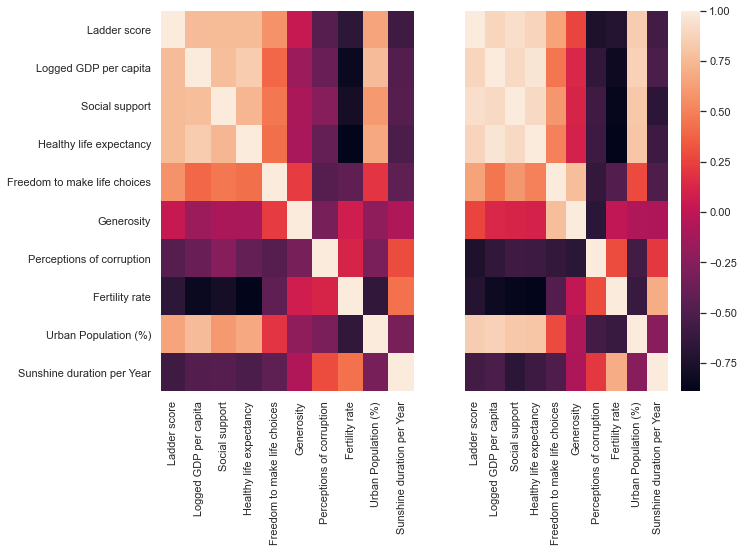

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 7))
sns.heatmap(df.corr(), ax=ax1, cbar=False)
sns.heatmap(df_region.corr(), ax=ax2, yticklabels=False)
plt.show()
fig.savefig('heatmaps.jpg')

# Boxplots

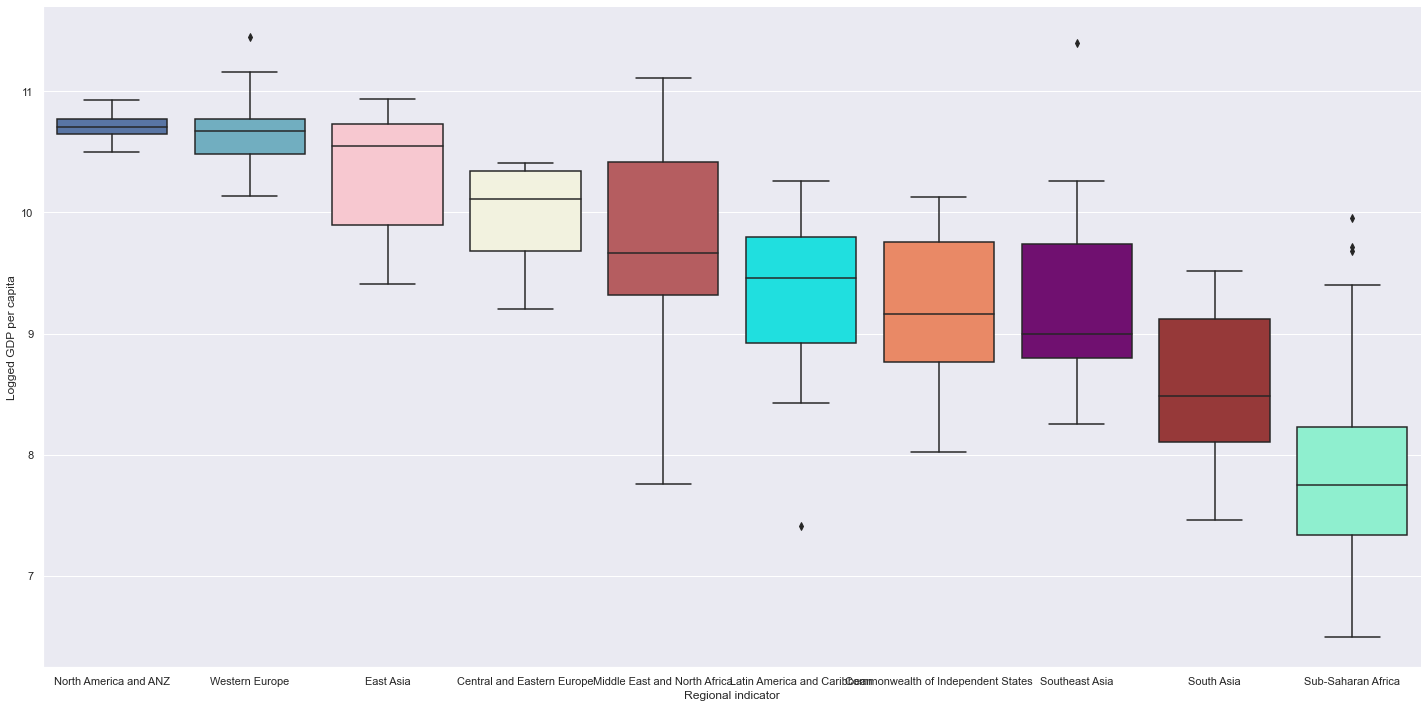

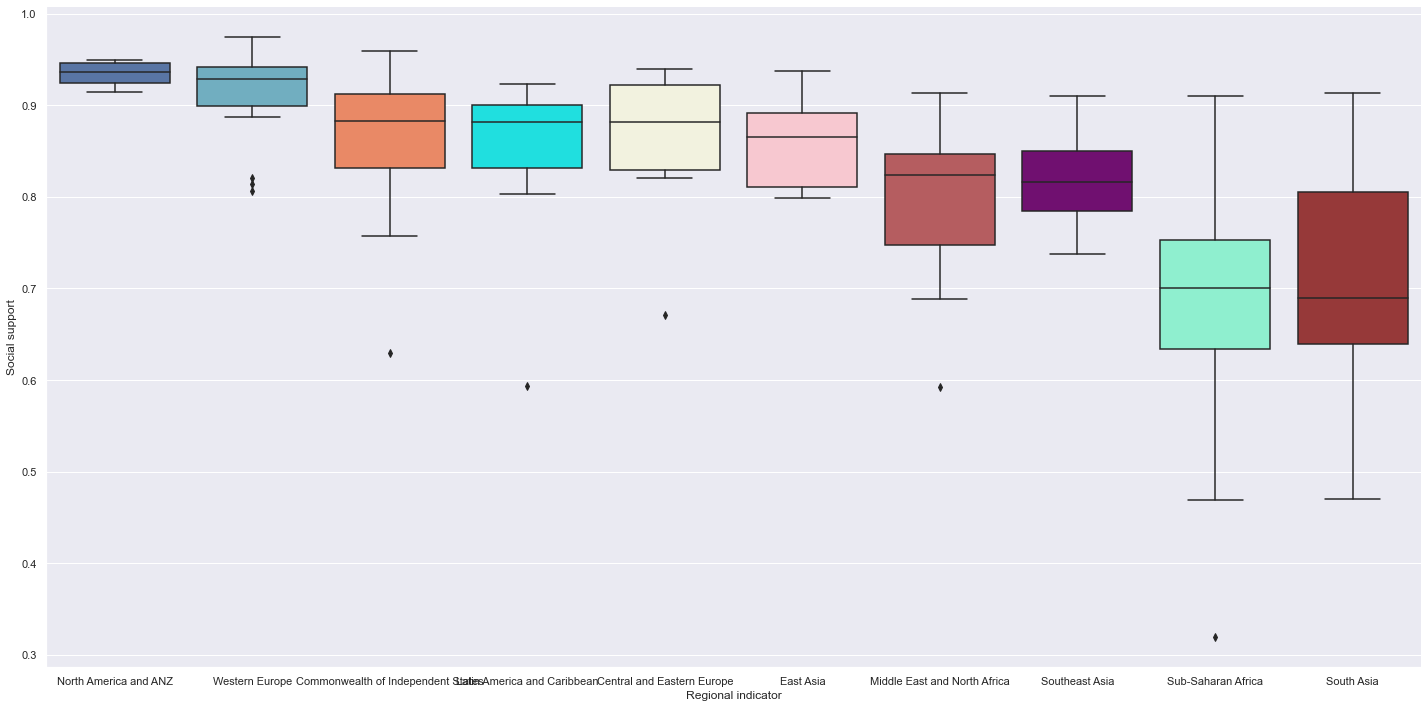

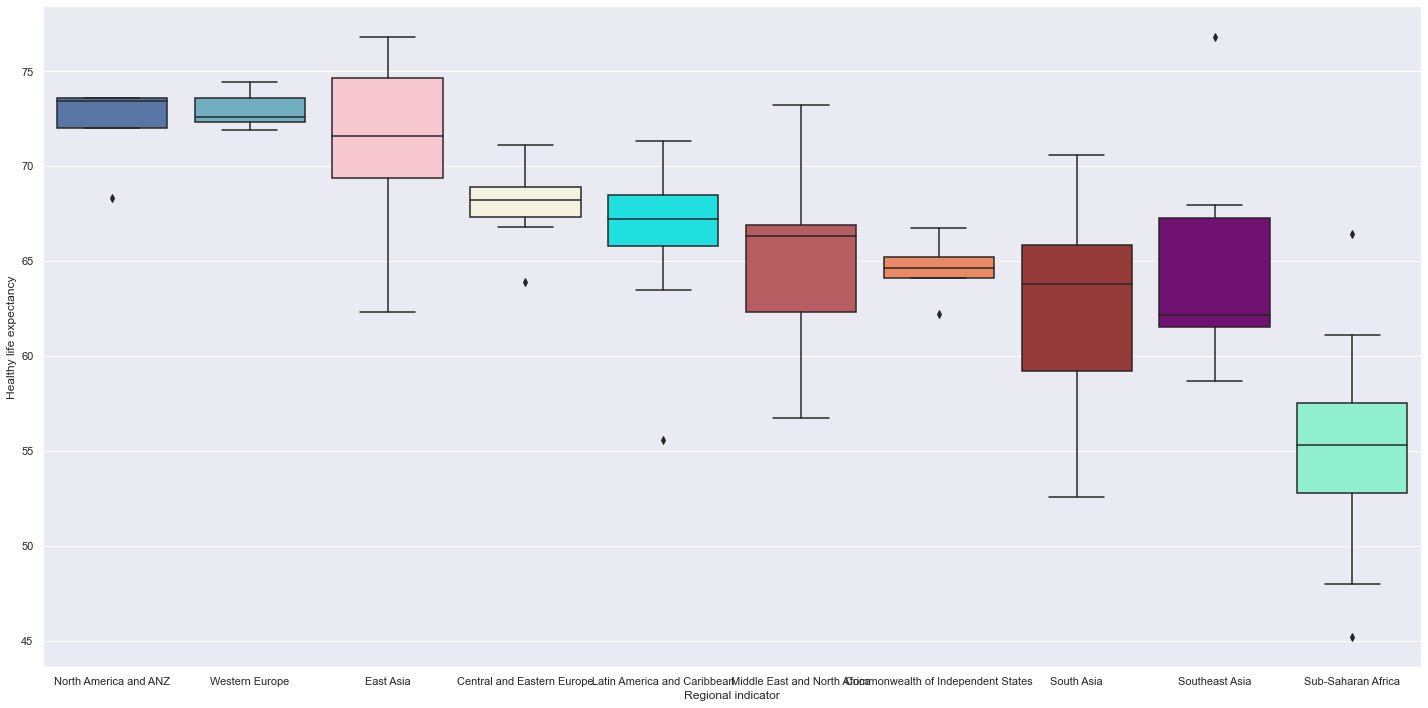

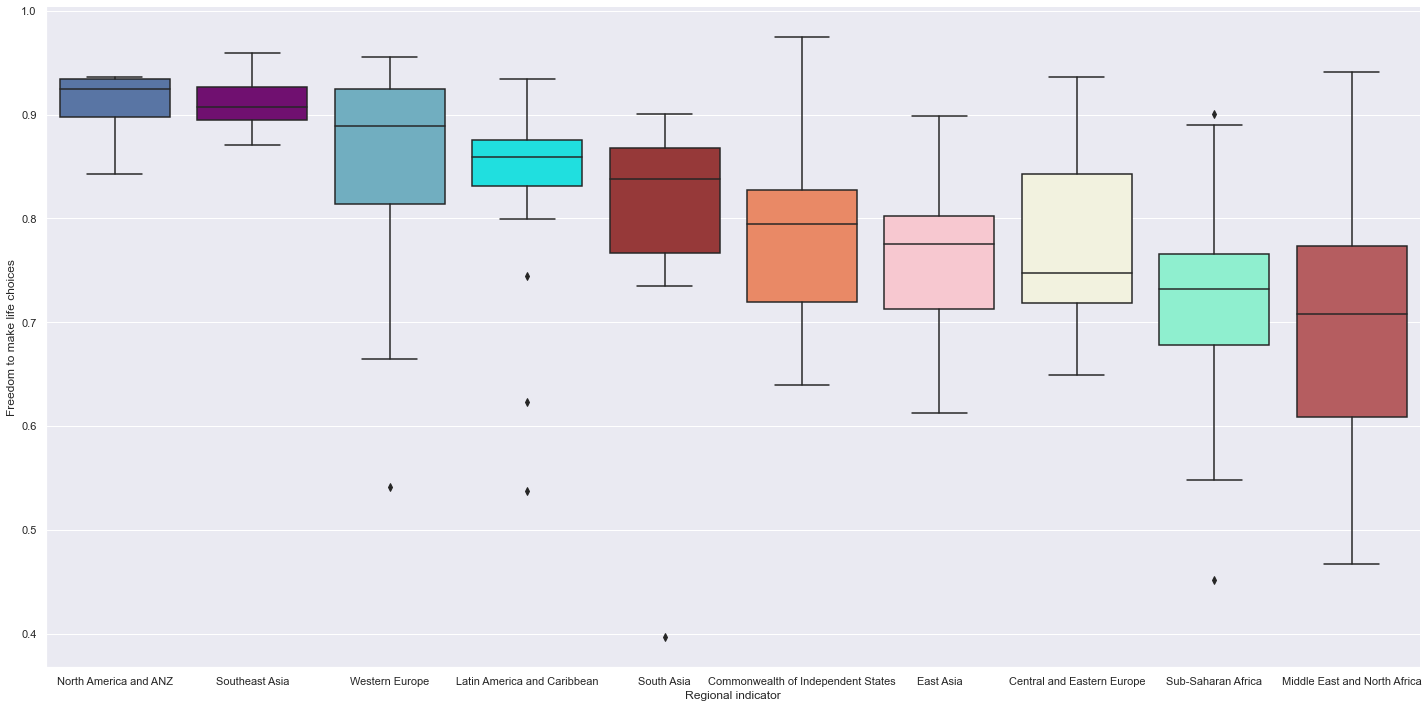

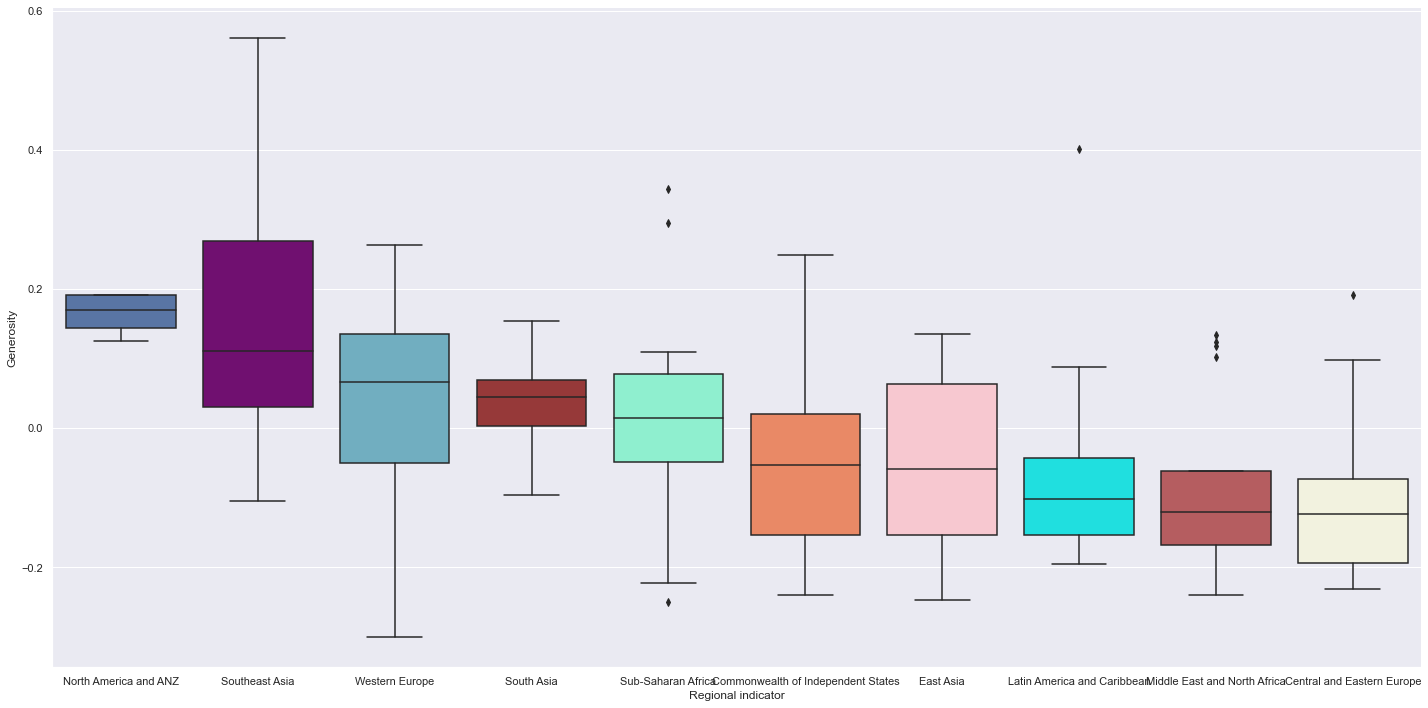

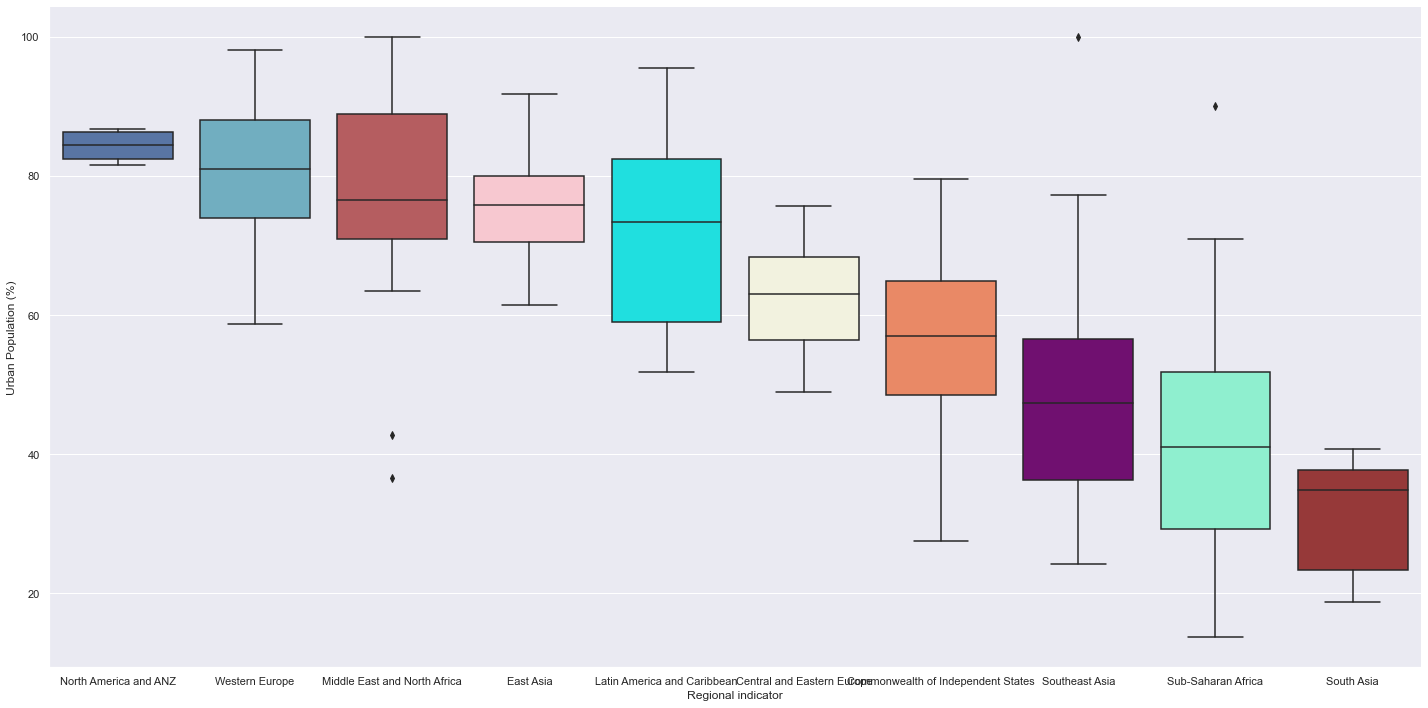

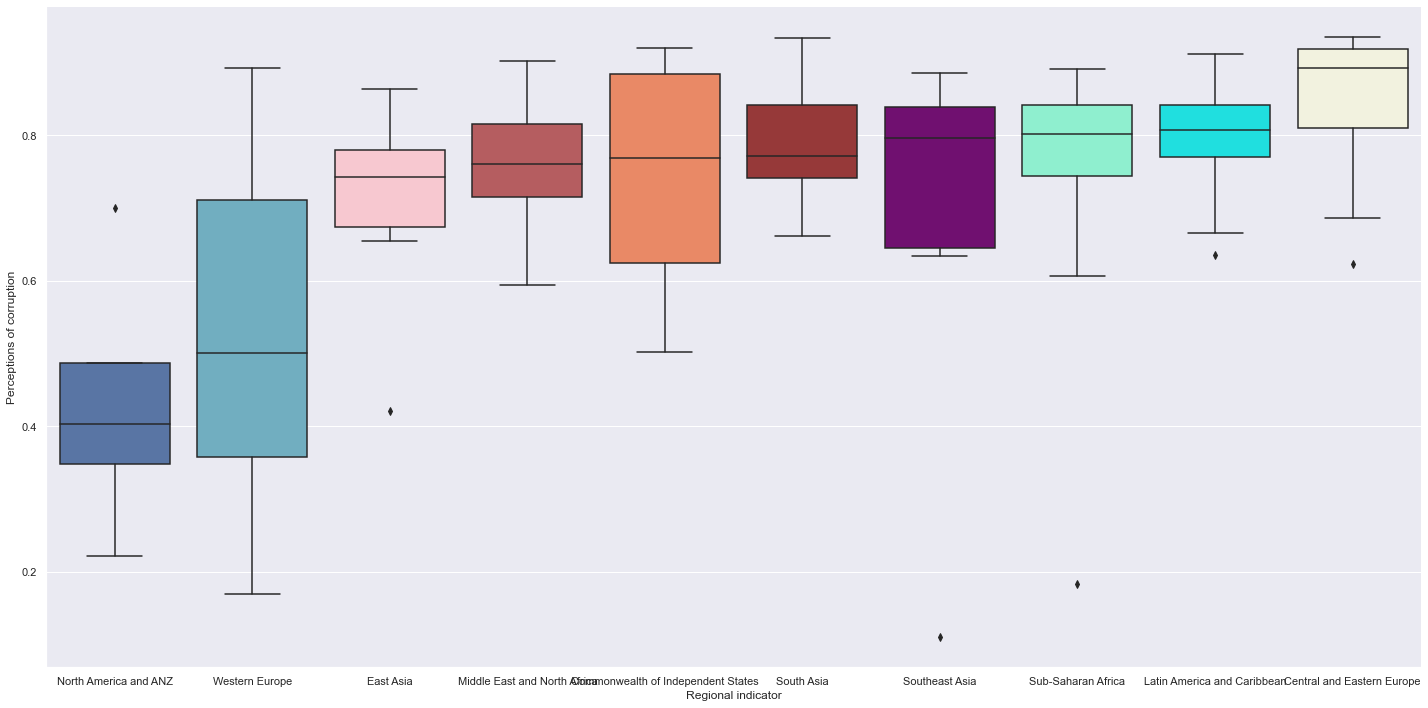

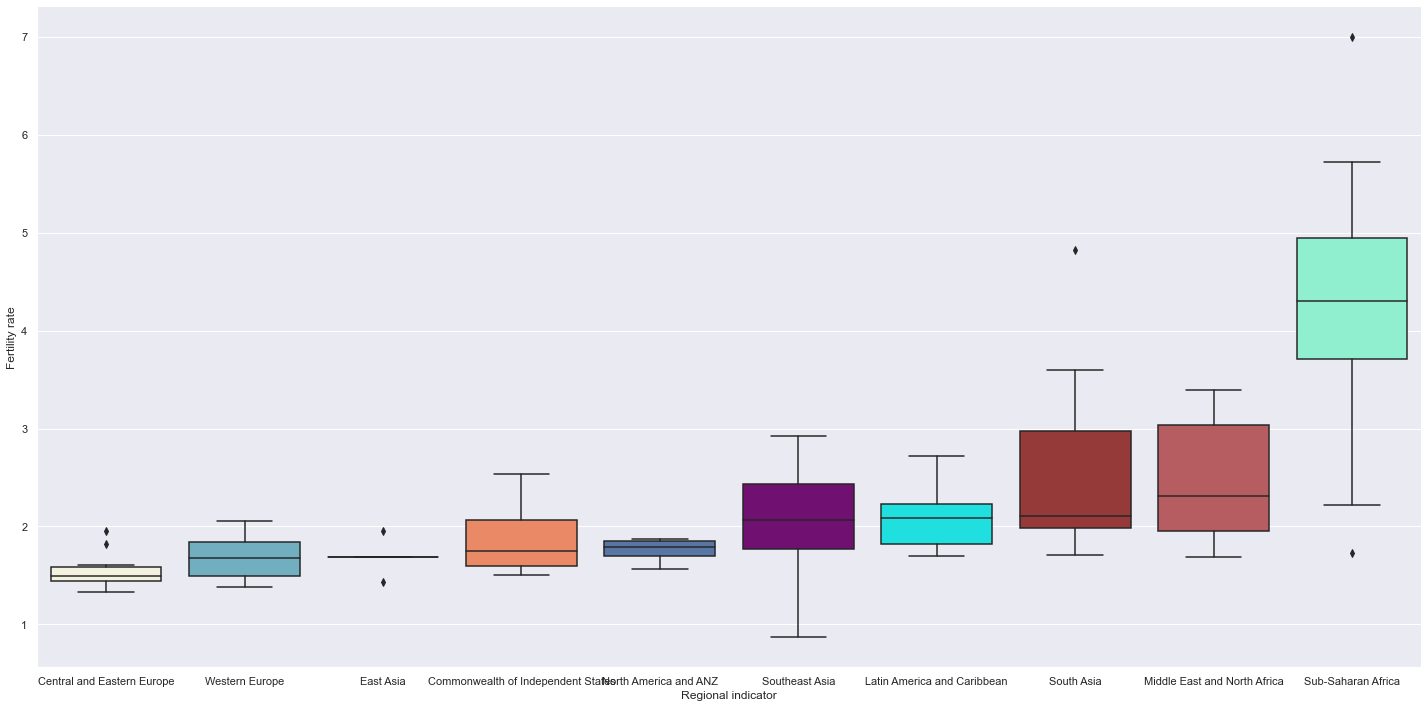

In [13]:
col=['Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity', 'Urban Population (%)']
my_pal = {"Western Europe": "cubehelix"[0], 'North America and ANZ': "cubehelix"[2],
          'Middle East and North Africa':"rocket"[0],
         'Latin America and Caribbean':'cyan','Central and Eastern Europe':"beige",
          'Southeast Asia': 'purple','Commonwealth of Independent States':'coral',
          'Sub-Saharan Africa':'aquamarine', 'East Asia':'pink', 'South Asia':'brown'}
for i in range(len(col)):
    my_order = df.groupby(by=['Regional indicator'])[col[i]].median().sort_values(ascending=False).index
    sns.catplot(data=df, x='Regional indicator', y=col[i], kind='box', height = 10, aspect=2, palette=my_pal, order=my_order)

col=['Perceptions of corruption', 'Fertility rate']
my_pal = {"Western Europe": "cubehelix"[0], 'North America and ANZ': "cubehelix"[2],
          'Middle East and North Africa':"rocket"[0],
         'Latin America and Caribbean':'cyan','Central and Eastern Europe':"beige",
          'Southeast Asia': 'purple','Commonwealth of Independent States':'coral',
          'Sub-Saharan Africa':'aquamarine', 'East Asia':'pink', 'South Asia':'brown'}
for i in range(len(col)):
    my_order = df.groupby(by=['Regional indicator'])[col[i]].median().sort_values(ascending=True).index
    sns.catplot(data=df, x='Regional indicator', y=col[i], kind='box', height = 10, aspect=2, palette=my_pal, order=my_order)

# Analysis on continent level => top3

In [14]:
#create a new ranking per region

for i in df_region.iloc[:, np.r_[1:5,8,9]]:
        df_region["Rank_"+i] = df_region[i].rank(ascending=0) 
for i in df_region.iloc[:, np.r_[6,7]]:
        df_region["Rank_"+i] = df_region[i].rank(ascending=1) 

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Central and Eastern Europe to Western Europe
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Ladder score                       10 non-null     float64
 1   Logged GDP per capita              10 non-null     float64
 2   Social support                     10 non-null     float64
 3   Healthy life expectancy            10 non-null     float64
 4   Freedom to make life choices       10 non-null     float64
 5   Generosity                         10 non-null     float64
 6   Perceptions of corruption          10 non-null     float64
 7   Fertility rate                     10 non-null     float64
 8   Urban Population (%)               10 non-null     float64
 9   Sunshine duration per Year         10 non-null     float64
 10  Rank_Logged GDP per capita         10 non-null     float64
 11  Rank_Social support         

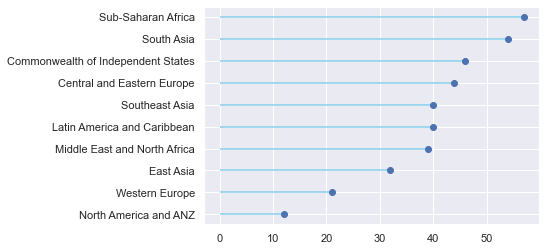

In [15]:
#graph of the regional ranking 

total_rank=df_region.iloc[:, np.r_[10:17]].sum(axis=1).sort_values(ascending=True)
my_range=range(1,len(total_rank.index)+1)

plt.hlines(y=my_range, xmin=0, xmax=total_rank, color='skyblue')
plt.plot(total_rank, my_range, "o")
plt.yticks(my_range, total_rank.index)
plt.savefig('rank_by_region_lolipop.jpg')

In [16]:
top3=df[df['Regional indicator'].isin(['Western Europe','North America and ANZ','East Asia'])]
top3.to_excel('top3.xlsx', index=False)
top3.head()

# Confidence intervals

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import norm

#on sunshine duration
sunshine = list(top3['Sunshine duration per Year'])
norm.interval(0.95,loc=np.mean(sunshine),scale=np.std(sunshine)/np.sqrt(len(sunshine)))

(1908.4192631297403, 2289.4945301796984)

In [19]:
#on health life
age = list(top3['Healthy life expectancy'])
norm.interval(0.95,loc=np.mean(age),scale=np.std(age)/np.sqrt(len(age)))

(71.57794646801783, 73.28735755585309)

#  Hypothesis testing

In [20]:
#on fertility value 
from scipy.stats import  ttest_ind,ttest_1samp
p_two_sided=0.05
p_one_sided=p_two_sided/2

st, pvalue=ttest_1samp(top3['Fertility rate'],2)
if p_one_sided> pvalue and st<0:
    print('Mummy was right, fertility rate is low, below 2')
else: print('Bullshit')

Mummy was right, fertility rate is low, below 2


In [21]:
#on urban rate
p_two_sided=0.05
p_one_sided=p_two_sided/2

st, pvalue=ttest_1samp(top3['Urban Population (%)'],85)
if p_one_sided> pvalue and st<0:
    print('Mummy was right, this is the countryside ! Urban rate is below 85%')
else: print('Bullshit')

Mummy was right, this is the countryside ! Urban rate is below 85%


# Final ranking

In [22]:
final_top=top3.copy()

for i in final_top.iloc[:, np.r_[1:7,10,11]]:
        final_top["Rank_"+i] = final_top[i].rank(ascending=0) 
for i in final_top.iloc[:, np.r_[8,9]]:
        final_top["Rank_"+i] = final_top[i].rank(ascending=1) 

final_top['final_score']=final_top.iloc[:, np.r_[12:21]].sum(axis=1)
final_top['old_rank']=top3.index

final_top.sort_values(by='final_score', ascending=True, inplace=True, ignore_index=True)

,Country,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Fertility rate,...,Rank_Logged GDP per capita,Rank_Social support,Rank_Healthy life expectancy,Rank_Freedom to make life choices,Rank_Urban Population (%),Rank_Sunshine duration per Year,Rank_Perceptions of corruption,Rank_Fertility rate,final_score,old_rank
0,Denmark,Western Europe,7.6456,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.7800,...,9.0,2.0,19.0,2.0,7.0,25.0,1.0,22.0,78.0,1
1,Norway,Western Europe,7.4880,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.8400,...,3.0,4.0,13.0,1.0,13.0,30.0,5.0,23.5,85.0,4
2,Switzerland,Western Europe,7.5599,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.5700,...,4.0,7.0,4.0,9.0,24.0,26.0,6.0,10.5,94.0,2
3,Finland,Western Europe,7.8087,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.7400,...,17.0,3.0,27.0,3.0,11.0,20.0,2.0,18.5,95.0,0
4,Sweden,Western Europe,7.3535,10.758794,0.926311,72.600769,0.939144,0.111615,0.250880,1.8700,...,11.0,16.0,16.0,5.0,8.0,19.0,4.0,26.5,97.0,6
5,Australia,North America and ANZ,7.2228,10.720596,0.944855,73.604538,0.915432,0.190460,0.415169,1.7400,...,14.0,6.0,8.0,10.0,10.0,3.0,11.0,18.5,97.5,11
6,Netherlands,Western Europe,7.4489,10.812712,0.939139,72.300919,0.908548,0.207612,0.364717,1.7700,...,7.0,9.0,22.0,11.0,4.0,22.0,8.0,20.5,100.0,5
7,Iceland,Western Europe,7.5045,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.9700,...,10.0,1.0,15.0,4.0,3.0,31.0,22.0,30.0,101.0,3
8,New Zealand,North America and ANZ,7.2996,10.500943,0.949119,73.202629,0.936217,0.191598,0.221139,1.8700,...,23.0,5.0,12.0,6.0,9.0,17.0,3.0,26.5,106.5,7
9,Luxembourg,Western Europe,7.2375,11.450681,0.906912,72.599998,0.905636,-0.004621,0.367084,1.6200,...,1.0,20.0,17.0,12.0,6.0,24.0,9.0,12.0,110.0,9


In [26]:
final_top.to_excel('final_top.xlsx')